In [13]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv('data/train.csv')

<Axes: >

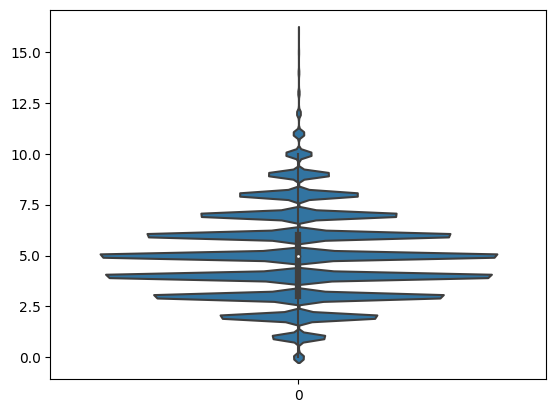

In [11]:
sns.violinplot(data['MonsoonIntensity'])

In [41]:
y_decision = (y >= 0.50448).astype(int)

np.corrcoef(y,y_decision)

array([[1.        , 0.80231984],
       [0.80231984, 1.        ]])

In [44]:
from sklearn.linear_model import LogisticRegression, LinearRegression


X = data.drop(columns=['FloodProbability'])
y = data['FloodProbability']

log_regression = LinearRegression()
log_regression.fit(X, y)

LinearRegression()

In [45]:
y_pred = log_regression.predict(X)
np.mean((y_pred-y)**2)**0.5

0.020092214329031546

In [46]:
min(y_pred)

0.3025239861343118

In [54]:
data_test = pd.read_csv('data/test.csv')
data_test

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,...,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,...,4,3,2,6,4,6,8,4,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745300,1863257,5,4,8,3,5,4,4,5,5,...,5,6,1,3,5,6,4,4,6,6
745301,1863258,4,4,2,12,4,3,4,3,5,...,3,7,4,4,3,5,5,3,5,4
745302,1863259,5,7,9,5,5,6,7,5,5,...,6,11,3,11,4,5,9,5,5,4
745303,1863260,4,7,6,3,5,2,3,8,6,...,6,6,8,6,2,3,8,7,5,5


In [49]:
y_test = log_regression.predict(data_test)

In [60]:
dic = {'FloodProbability': y_test}
submission = pd.DataFrame.from_dict(dic)
submission.reset_index(drop=True, inplace=True)
submission['id'] = data_test['id']
submission.set_index('id', inplace=True)


In [61]:

submission.to_csv('my_submission.csv')